In [13]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
n_classes = 3

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 4500 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names


In [9]:
len(dataset)

141

2024-06-03 11:49:11.944971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


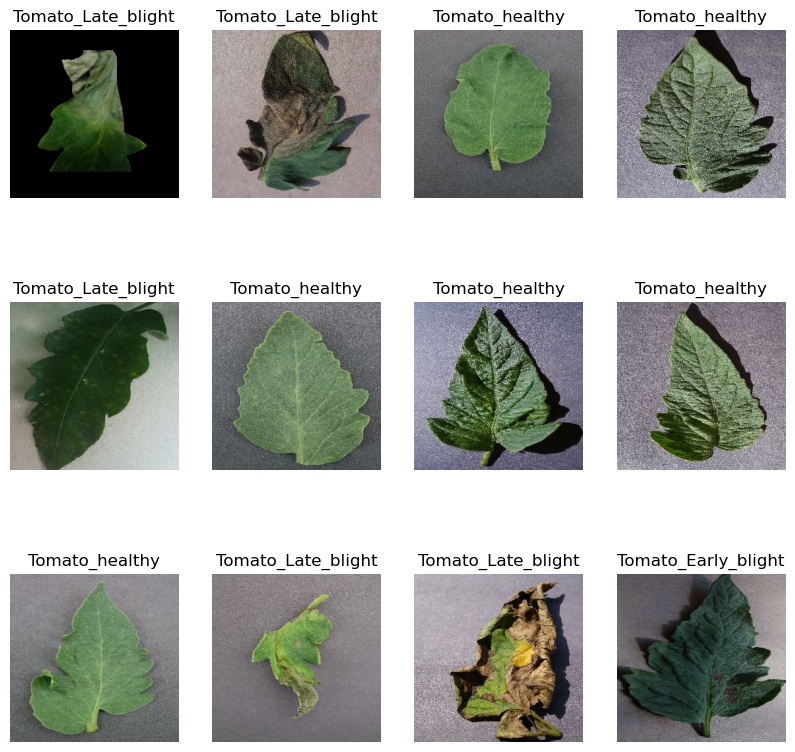

In [18]:
plt.figure(figsize=(10,10))
for images_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [19]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [22]:
train_ds = dataset.take(112)

In [23]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [24]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [25]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [26]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [72]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [73]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [74]:
len(train_ds)

112

In [75]:
len(val_ds)

14

In [76]:
len(test_ds)

15

In [77]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [79]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [81]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [82]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [84]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [86]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.4467 - loss: 1.0133 - val_accuracy: 0.7299 - val_loss: 0.6266
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1686s 15s/step - accuracy: 0.7497 - loss: 0.6181 - val_accuracy: 0.8348 - val_loss: 0.4296
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.8441 - loss: 0.3765 - val_accuracy: 0.8348 - val_loss: 0.4173
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8515 - loss: 0.3574 - val_accuracy: 0.8326 - val_loss: 0.4180
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.8504 - loss: 0.3446 - val_accuracy: 0.8125 - val_loss: 0.4147
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8796 - loss: 0.2753 - val_accuracy: 0.7991 - val_loss: 0.4841
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.8833 - loss: 0.2906 - val_accuracy: 0.8371 - val_loss: 0.3669
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8843 - loss: 0.2624 - val_ac

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figure = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [88]:
for images_batch, labels_match in test_ds.take(1):
    print(images_batch[0].numpy())

[[[ 85.  89. 100.]
  [ 85.  89. 100.]
  [ 85.  89. 100.]
  ...
  [214. 208. 210.]
  [210. 204. 206.]
  [205. 199. 201.]]

 [[ 87.  91. 102.]
  [ 87.  91. 102.]
  [ 86.  90. 101.]
  ...
  [205. 199. 201.]
  [202. 196. 198.]
  [199. 193. 195.]]

 [[ 87.  91. 102.]
  [ 87.  91. 102.]
  [ 87.  91. 102.]
  ...
  [201. 195. 197.]
  [203. 197. 199.]
  [204. 198. 200.]]

 ...

 [[152. 139. 133.]
  [144. 131. 125.]
  [145. 132. 126.]
  ...
  [161. 150. 146.]
  [180. 169. 165.]
  [177. 166. 162.]]

 [[142. 129. 123.]
  [144. 131. 125.]
  [147. 134. 128.]
  ...
  [171. 160. 156.]
  [179. 168. 164.]
  [172. 161. 157.]]

 [[135. 122. 116.]
  [147. 134. 128.]
  [151. 138. 132.]
  ...
  [184. 173. 169.]
  [178. 167. 163.]
  [164. 153. 149.]]]


2024-06-03 17:57:27.258764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidenced

In [ ]:
plt.figure(figsize = (15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.")
        plt.axis("off")
        